In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf

from pandas import read_csv
import sys
import os
import warnings

# Stats Model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import glob
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import *
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

### 1. Data Preprocessing

In [54]:
cwd = os.path.abspath('./data')
file_list = os.listdir(cwd)
print(file_list)
# csv = glob.glob('*.{}'.format('csv'))

['APU0000702111.csv', 'CPIAPPSL.csv', 'CPIMEDSL.csv', 'CSUSHPISA.csv', 'CUSR0000SAF116.csv', 'CUSR0000SEHF02.csv']


In [82]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

data_Main = pd.DataFrame(columns = ['DATE'])
for file in file_list:
    path = os.path.join(cwd, file)
    temp = pd.read_csv(path, parse_dates= ['DATE'])
    # print(temp.tail())
    data_Main = pd.DataFrame.merge(data_Main, temp, how = 'right', on = ['DATE'])

data_Main = data_Main.rename(columns = {'CPIMEDSL': 'Medical',
                                         'APU0000702111':'Bread',
                                         'CUSR0000SAF116': 'Alcohol', 
                                         'CUSR0000SEHF02': 'Utility',
                                         'CSUSHPISA' : 'Home',
                                         'CPIAPPSL': 'Apparel'})
data_Main['MonthYear'] = data_Main['DATE'].dt.to_period('M')
# data_Main = data_Main.set_index('DATE')

In [79]:
data_Main.head()

,DATE,Bread,Apparel,Medical,Home,Alcohol,Utility,MonthYear
0,1989-01-01,0.653,118.4,143.8,73.946,120.7,96.8,1989-01
1,1989-02-01,0.652,117.1,144.9,74.382,121.2,96.7,1989-02
2,1989-03-01,0.654,118.1,145.8,74.778,121.7,97.1,1989-03
3,1989-04-01,0.655,118.6,146.6,75.085,122.1,97.2,1989-04
4,1989-05-01,0.655,118.9,147.5,75.306,122.9,96.3,1989-05


In [77]:
federal_fund = pd.read_csv('fed_data/federal_fund_future_monthly.csv')

# Reformatting federal fund future date time variable to month-year
federal_fund = federal_fund.rename(columns={'Time':'Date', 'Last': 'FFF_Price', 'Change':'FFF_Change'})
federal_fund['Date'] = pd.to_datetime(federal_fund ['Date'])
federal_fund.sort_values(by='Date', ascending=True, inplace=True)
federal_fund['MonthYear'] = federal_fund['Date'].dt.to_period('M')
# federal_fund['Week'] = federal_fund['Date'].dt.to_period('W').dt.start_time

# Calculate monthly change for the 30-day federal fund future.
federal_fund['MonthlyChange'] = ((federal_fund['FFF_Price'] / federal_fund['FFF_Price'].shift(1)) -1)*100
federal_fund['M1_ImpliedRate'] = 100 - federal_fund['FFF_Price']
selected_columns = ['MonthYear','M1_ImpliedRate', 'MonthlyChange', 'FFF_Price']
federal_fund = federal_fund[selected_columns]
# Drop NA
federal_fund.dropna(axis=0, inplace=True)

federal_fund.tail()
# federal_fund.to_csv('fed_data/federal_fund.csv')

,MonthYear,M1_ImpliedRate,MonthlyChange,FFF_Price
417,2023-04,5.445,0.031738,94.555
416,2023-04,5.365,0.084607,94.635
425,2023-04,5.025,0.359275,94.975
415,2023-04,5.250,-0.236904,94.750
414,2023-04,4.960,0.306069,95.040


In [105]:
data_final = pd.DataFrame.merge(data_Main, federal_fund, how = 'right', on = ['MonthYear'])
data_final.dropna(axis=0, inplace=True)
data_final = data_final[['MonthYear', 'FFF_Price', 'Medical', 'Utility', 'Bread', 'Alcohol', 'Home', 'Apparel']]
data_final = data_final.set_index('MonthYear')
data_final.head()

,FFF_Price,Medical,Utility,Bread,Alcohol,Home,Apparel
MonthYear,,,,,,,
1989-01,90.88,143.8,96.8,0.653,120.7,73.946,118.4
1989-02,90.63,144.9,96.7,0.652,121.2,74.382,117.1
1989-03,90.14,145.8,97.1,0.654,121.7,74.778,118.1
1989-04,90.16,146.6,97.2,0.655,122.1,75.085,118.6
1989-05,90.20,147.5,96.3,0.655,122.9,75.306,118.9


### 2. Tests

In [87]:
maxlag = 12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Significance Level    = {signif}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [106]:
# granger = grangers_causation_matrix(data_final, variables = ['FFF_Price', 'Medical', 'Utility', 'Bread', 'Alcohol', 'Home', 'Apparel'])
print(granger)
data_final_log = np.log(data_final).diff().dropna()

In [107]:

for name, column in data_final_log.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "FFF_Price" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 5
 => P-Value = 0.0048. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Medical" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 18
 => P-Value = 0.015. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Utility" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 11
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Bread" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 4
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Alcohol" 
    ----------------------

In [139]:
model_var = VAR(data_final_log)
for i in range(12):
    result = model_var.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 0
AIC :  -72.20074632689217
Lag Order = 1
AIC :  -73.36933957213628
Lag Order = 2
AIC :  -73.66834980053042
Lag Order = 3
AIC :  -73.89197470621953
Lag Order = 4
AIC :  -73.83382586412003
Lag Order = 5
AIC :  -73.80724633142039
Lag Order = 6
AIC :  -73.83486321199744
Lag Order = 7
AIC :  -73.75114788466308
Lag Order = 8
AIC :  -73.69362255901146
Lag Order = 9
AIC :  -73.66668885436852
Lag Order = 10
AIC :  -73.6001235616214
Lag Order = 11
AIC :  -73.52157764142453


Observed that AIC decreased til lag order 4 then increased. We chose lag 5. 

In [144]:
model_var_fitted = model_var.fit(5)
model_irf = model_var_fitted.irf(5)
res = model_irf.irfs
cum_res = model_irf.cum_effects
model_var_fitted.summary()

# for i in range(6):
#     print(res[i][1])

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Apr, 2023
Time:                     18:35:48
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -71.3020
Nobs:                     402.000    HQIC:                  -72.8153
Log likelihood:           11094.4    FPE:                8.85896e-33
AIC:                     -73.8072    Det(Omega_mle):     4.86011e-33
--------------------------------------------------------------------
Results for equation FFF_Price
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000034         0.000195            0.176           0.860
L1.FFF_Price         0.492781         0.052650            9.360           0.000
L1.Medical           0.114104         0.038658            2.

### Impulse Response

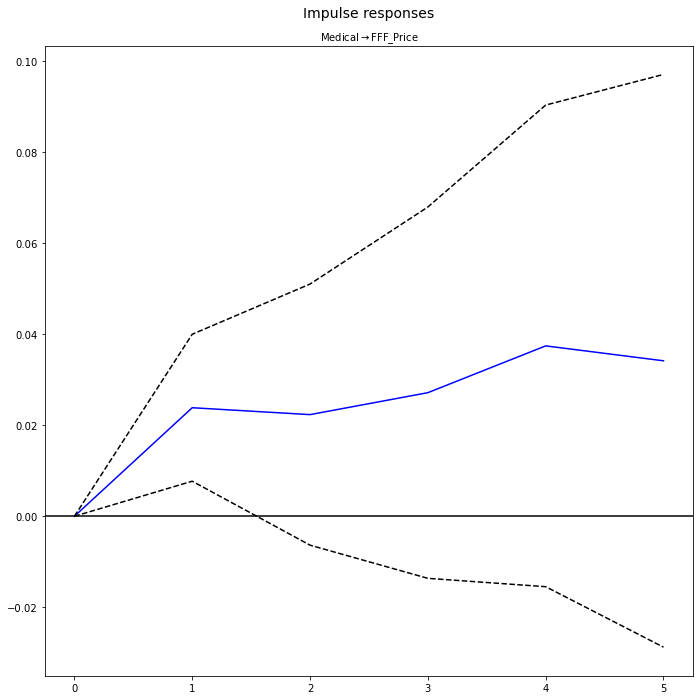

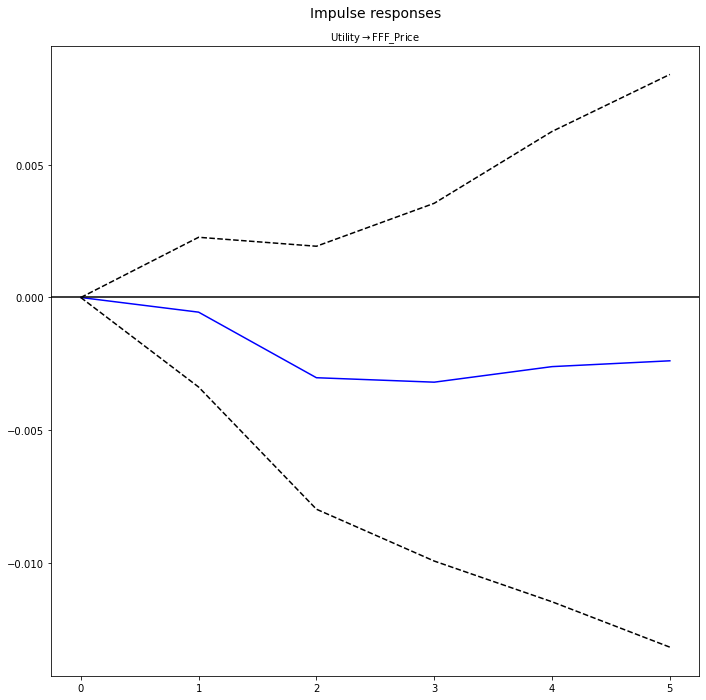

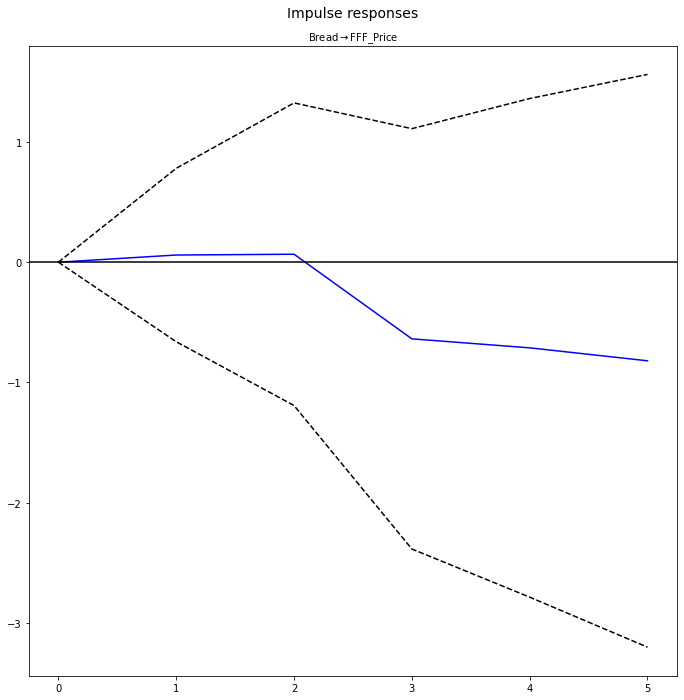

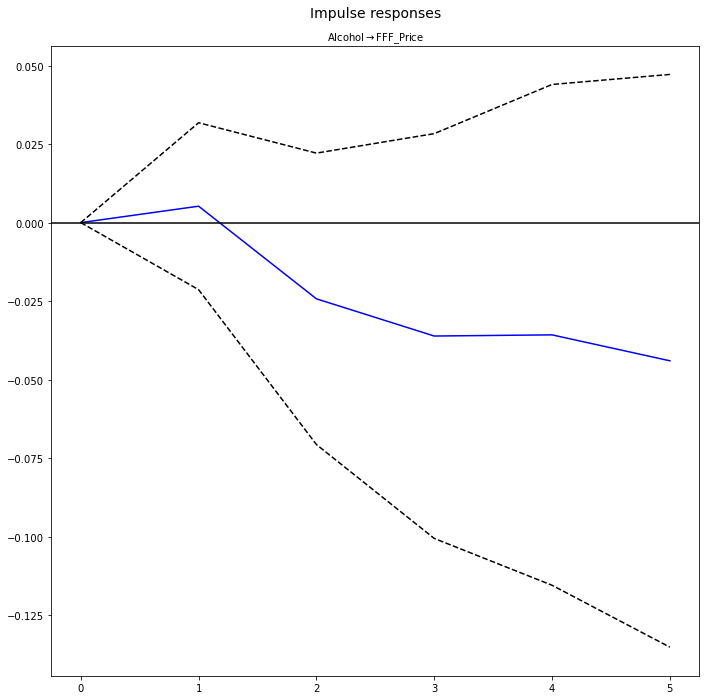

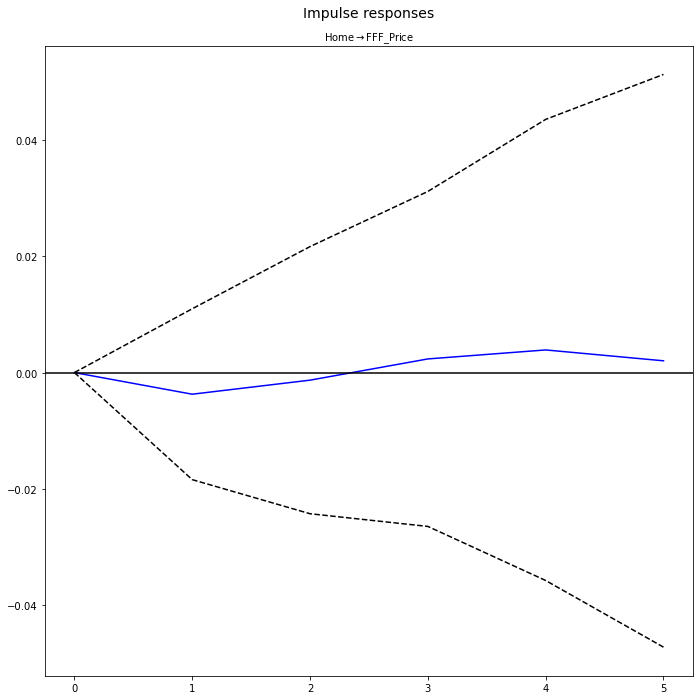

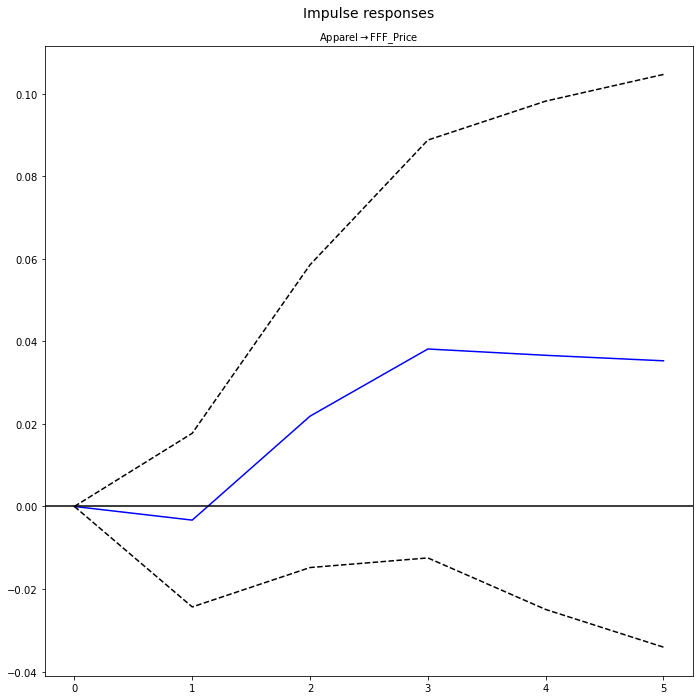

In [141]:
model_irf.plot(response = 'FFF_Price', impulse='Medical',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)
plt.savefig('graphs/impulse_medical.png')

model_irf.plot(response = 'FFF_Price', impulse='Utility',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

plt.savefig('graphs/impulse_utility.png')

model_irf.plot(response = 'FFF_Price', impulse='Bread',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

plt.savefig('graphs/impulse_bread.png')

model_irf.plot(response = 'FFF_Price', impulse='Alcohol',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

plt.savefig('graphs/impulse_alcohol.png')

model_irf.plot(response = 'FFF_Price', impulse='Home',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

plt.savefig('graphs/impulse_home.png')

model_irf.plot(response = 'FFF_Price', impulse='Apparel',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

plt.savefig('graphs/impulse_apparel.png')

In [135]:
# Determine lag for vecm
lag_order = select_order(data=data_final, maxlags=10, deterministic="li")
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-10.08,-9.450,4.182e-05,-9.832
1,-10.62,-9.496*,2.444e-05,-10.17*
2,-10.75,-9.138,2.138e-05,-10.11
3,-10.93,-8.821,1.797e-05,-10.09
4,-10.93,-8.334,1.793e-05,-9.903
5,-10.93,-7.843,1.797e-05,-9.709
6,-11.02,-7.436,1.657e-05,-9.599
7,-10.99,-6.916,1.711e-05,-9.376
8,-11.02,-6.452,1.674e-05,-9.210
9,-11.04,-5.980,1.654e-05,-9.034


In [136]:
rank_test= select_coint_rank(data_final, 1 ,6, method = "trace")
rank_test.rank


3

In [137]:
model_vec = VECM(data_final, deterministic="li", k_ar_diff = 6,  coint_rank = 3)
model_vec_fitted = model_vec .fit()
model_vec_irf = model_vec_fitted.irf(5)
model_vec_irf_test = model_vec_irf.irfs
for i in range(6):
    print(model_vec_irf_test[i][1])

[0. 1. 0. 0. 0. 0. 0.]
[ 0.7963884   1.06319803  0.00444461 -2.35010162 -0.01837201 -0.23223379
  0.07798512]
[ 0.89390318  1.14532771 -0.00807548 -5.54038073 -0.07672448 -0.23745234
  0.1711663 ]
[ 1.13691291  1.35537549 -0.00892886 -5.20778992  0.02943594 -0.13671011
  0.12220812]
[ 1.76884705e+00  1.30767704e+00 -2.88043365e-03 -8.37778945e+00
  6.92549161e-02 -2.35270005e-01  2.81968260e-01]
[ 1.98682149  1.30623245 -0.01924559 -8.78209311  0.06416428 -0.14033146
  0.25829454]


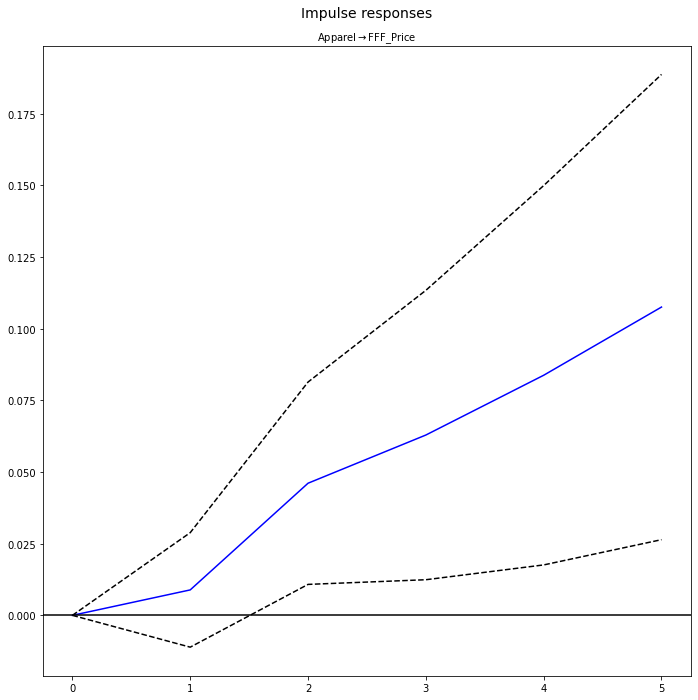

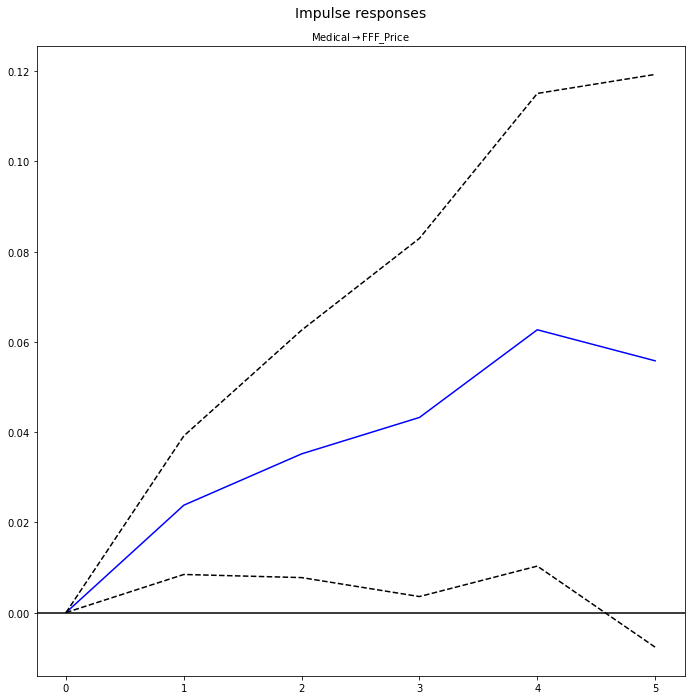

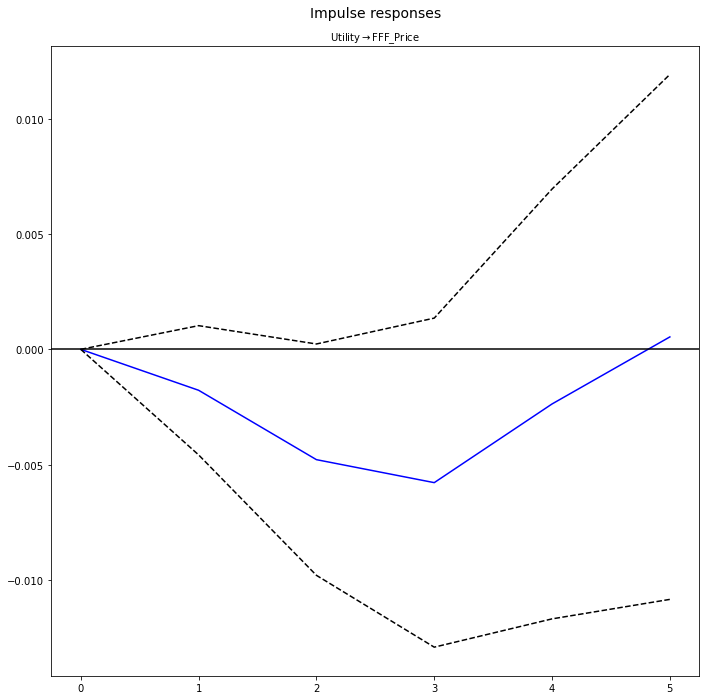

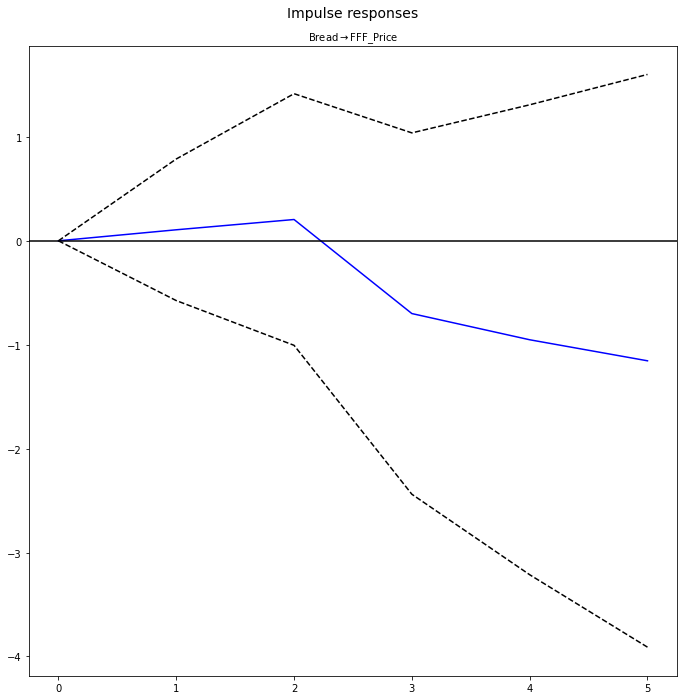

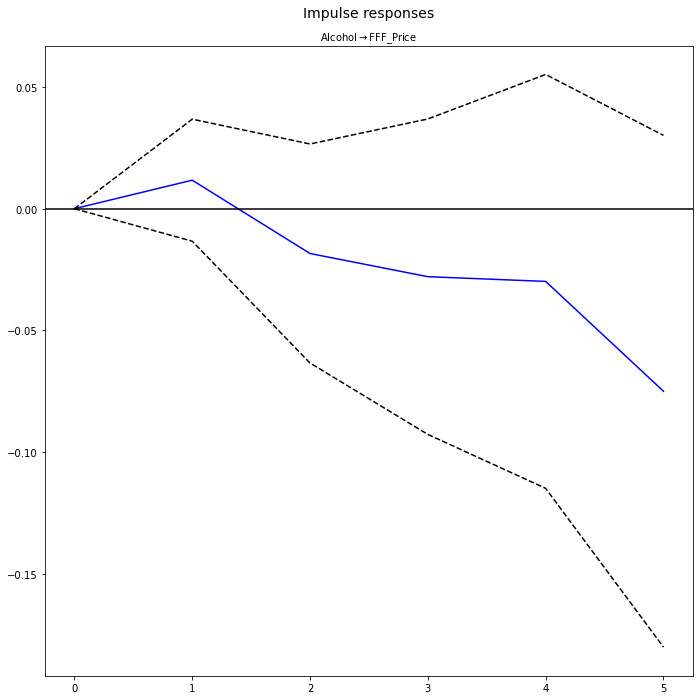

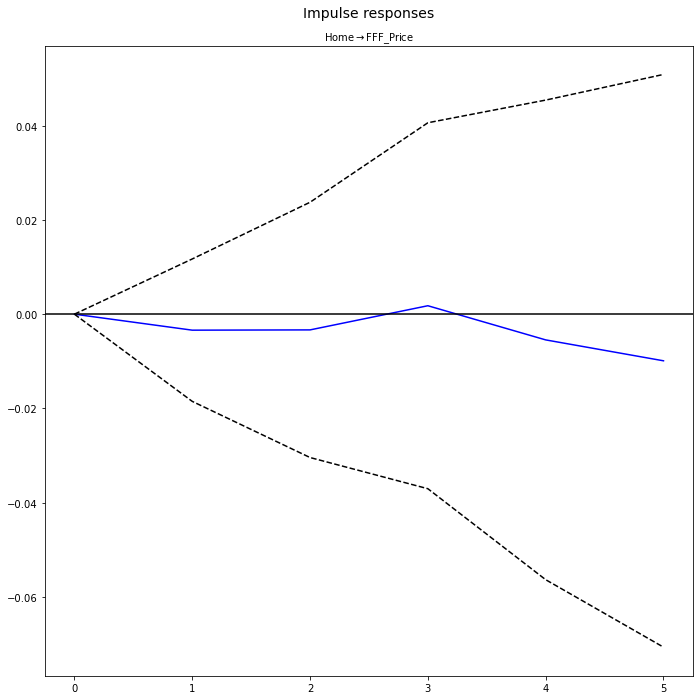

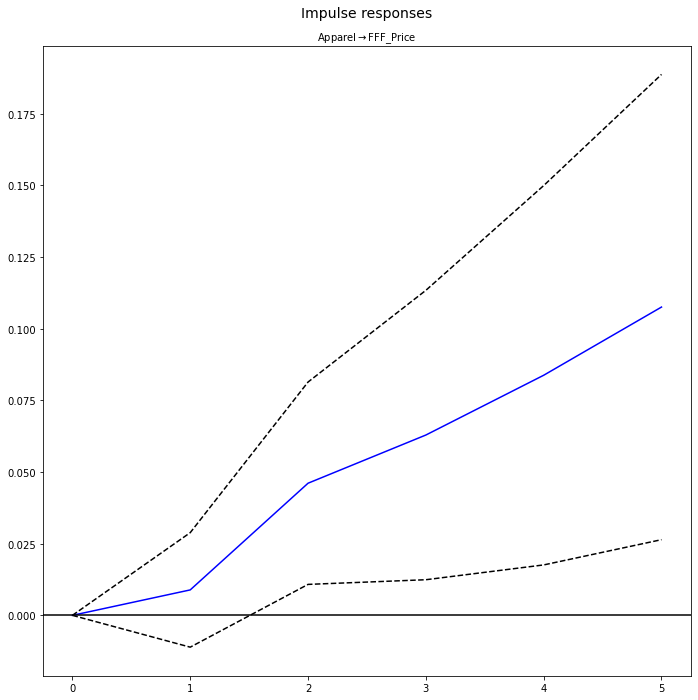

In [138]:
model_vec_irf.plot(response = 'FFF_Price', impulse='Medical',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

model_vec_irf.plot(response = 'FFF_Price', impulse='Utility',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

model_vec_irf.plot(response = 'FFF_Price', impulse='Bread',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

model_vec_irf.plot(response = 'FFF_Price', impulse='Alcohol',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

model_vec_irf.plot(response = 'FFF_Price', impulse='Home',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

model_vec_irf.plot(response = 'FFF_Price', impulse='Apparel',
                       subplot_params = {'fontsize': 10}, seed = 1, signif = 0.05)

### Further Studies on Stock Returns (Deprecated for this Project)

In [81]:
# # Download data from yfinance API
# spy = yf.download(tickers='SPY', start='2006-01-01', end='2023-3-8', interval='1wk')

# # Calculate monthly return for the index
# spy['WeeklyReturn'] = (spy['Close'] / spy['Close'].shift(1)) -1

# # Reformat time period
# spy['Date'] = pd.to_datetime(spy.index)
# spy['MonthYear'] = spy['Date'].dt.to_period('M')
# spy['Week'] = spy['Date'].dt.to_period('W').dt.start_time
# spy = spy.assign(Index=range(len(spy))).set_index('Index')

# # Drop NA
# spy.dropna(axis=0, inplace=True)

# spy.tail()

# fed_spy_data = pd.merge(spy, federal_fund, on=['Week'])
# fed_spy_data['Week'] = fed_spy_data['Week'].astype(str)
# selected_columns = ['Week', 'WeeklyReturn', 'Close', 'FFF_Price', 'FFF_Change', '%Chg', 'M1_ImpliedRate']
# fed_spy_data = fed_spy_data[selected_columns]
# # data.drop(columns='Open', 'High','Low')
# fed_spy_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,WeeklyReturn,Date,MonthYear,Week
Index,,,,,,,,,,
892,409.790009,416.489990,405.010010,408.040009,408.040009,376978100.0,-0.010452,2023-02-05,2023-02,2023-01-30
893,408.720001,415.049988,404.049988,407.260010,407.260010,380547800.0,-0.001912,2023-02-12,2023-02,2023-02-06
894,403.059998,404.160004,393.640015,396.380005,396.380005,370835000.0,-0.026715,2023-02-19,2023-02,2023-02-13
895,399.869995,404.450012,392.329987,404.190002,404.190002,451756200.0,0.019703,2023-02-26,2023-02,2023-02-20
896,405.049988,407.450012,396.589996,398.920013,398.920013,255853100.0,-0.013038,2023-03-05,2023-03,2023-02-27


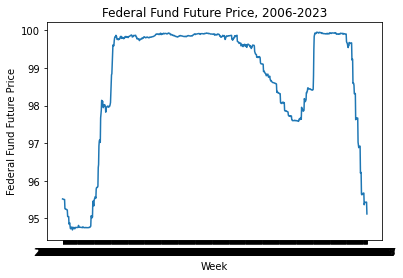

In [88]:
# Create figure and plot space
# plt.plot(fed_spy_data.Week,fed_spy_data.FFF_Price)


# plt.title('Federal Fund Future Price, 2006-2023')
# plt.xlabel('Week')
# plt.ylabel('Federal Fund Future Price')
# # plot.figsize((10,6))
# plt.savefig('fff_price.png')

In [91]:
# fed_spy_data.to_stata('data/fed_spy_data.dta')

c:\ProgramData\Anaconda3\lib\site-packages\pandas\io\stata.py:2397: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    %Chg   ->   _Chg

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)
